In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import clear_output
from datetime import datetime

pd.set_option('display.max_rows', 100)
sns.set()

### Lendo Dados do Sistema 'Comando'

In [3]:
comando = pd.read_csv('Dados\Extração Sistema Comando.csv', sep='|')

C:\Users\luisr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
comando.head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_INICIO,EVENTO_FIM,EVENTO_PRAZO,EVENTO_LATITUDE,EVENTO_LONGITUDE,POP_TITULO,POP_DESCRICAO,ORGAO_SIGLA,ORGAO_NOME,ACAO
0,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23 12:13:04,2015-02-23 14:18:52,NaN,NaN,NaN,Acidente com vítima(s),Acidente com vítima(s),PM,Polícia Militar,Registrar o acidente
1,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23 12:13:04,2015-02-23 14:18:52,NaN,NaN,NaN,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Desfazer o acidente
2,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23 12:13:04,2015-02-23 14:18:52,NaN,NaN,NaN,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Organizar o trânsito
3,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23 12:13:04,2015-02-23 14:18:52,NaN,NaN,NaN,Acidente com vítima(s),Acidente com vítima(s),BOMBEIROS,Corpo de Bombeiros,Prevenir perigo
4,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23 12:13:04,2015-02-23 14:18:52,NaN,NaN,NaN,Acidente com vítima(s),Acidente com vítima(s),BOMBEIROS,Corpo de Bombeiros,Atender vítima(s)


# Funções

In [5]:
def remover_acentos(string):

    item = string.lower()
    for a, b in zip(['á', 'é', 'í', 'ó', 'ú'], ['a', 'e', 'i', 'o', 'u']):
        item = item.replace(a, b)
    
    return item

In [6]:
def find_in_col(col, word_list, avoid):

    word_dict = {word:{'Contagem':0, 'Items':[], 'Index':[], 'Palavras':[]} for word in word_list}
    for word in word_list:

        for index, item in zip(col.index, col):
            if type(item)==float: continue
            new_item = remover_acentos(item)

            if word in new_item:
                
                word_lst = new_item.split()                
                for palavra in word_lst: 
                    if word in palavra:
                        break
                        
                if palavra not in avoid:                   
#                if sum([avoid_word in new_item for avoid_word in avoid])==0:
                    word_dict[word]['Contagem']+=1
                    word_dict[word]['Items'].append(new_item)     
                    word_dict[word]['Index'].append(index)
                    word_dict[word]['Palavras'].append(palavra)                            

    return word_dict
    

In [7]:
def format_col(col):
    
    for item, index in zip(col, col.index):
        
        lst = item.split(' ')
            
        if len(lst[0])>=3:
            if lst[0][2]=='h':
                new_item = ' '.join(lst[2:]); col[index]=new_item; continue
            
        if lst[-1][-1]==')':
            
            lst = item.split(' ')
            ind='a'
            for word in reversed(lst):
                
                if word[0]=='(':
                    ind = lst.index(word)
                    break
                    
            if ind!='a':
                new_item = ' '.join(lst[:ind])
                col[index]=new_item
      
    return new_col

In [8]:
def col_to_date(col):
    new_col = []
    cnt=0
    for item in col:
        cnt+=1
        clear_output(wait=True); print(f'{cnt}/{len(col)}')
        date = item.split(' ')[0].replace('-', '/').split('/');# date[0]=date[0][2:]
        date = '/'.join([date[i] for i in [1,0]])
        new_col.append(datetime.strptime(date, '%m/%Y').date())
    
    return pd.Series(new_col, index = col.index)

---

# LIMPEZA E MINEIRAÇÃO DOS DADOS

# IDENTIFICANDO REGISTROS POR TIPO DE VEÍCULO INVOLVIDO

#### Configurações

In [9]:
siglas = { 'MT': 'moto',
           'VP': 'veiculo de passeio',
           'ON': 'onibus',
           'CM': 'caminhao',
           'UT': 'utilitario',
           'AC': 'acidente'
}

In [10]:
coluna_de_busca = 'EVENTO_TITULO'

buscas = ['mt', 'vp', 'on', 'cm', 'ut', 'ac']

out_mt = ['almte', 'almte.', 'cmte', 'cmte.', 'comte',   # Variáveis 'out' encontradas posteriormente
          'mt.ocupando', 'mte.', 'mtxon', 'samto', 'semt.',
          'smtr', 'vpxmt', 'xmt']

out_ut = ['(manutenção', '(manutenção)', '(outdoor)', 'adutora',
          'aeronautas', 'auto', 'auto-estrada', 'autorizado', 'autorizado"',
          'autorizado)', 'b19576xutxvp)', 'couto', 'dutra.', 'estrutura',
          'estrutura.', 'frutas', 'luther', 'manut/limpeza', 'manutenção',
          'mutera', 'nautico)', 'obra/outros', 'outdoor', 'outono"',
          'outubro', 'souto', 'utilitario', 'viaduto', 'viaduto.']

out = out_mt + out_ut

#### Realizando busca por siglas de veículos

In [11]:
resultado_busca = find_in_col(comando[coluna_de_busca], buscas, avoid=out)

#### Salvando/Recarregando Resultado

In [41]:
import json
#json_res = json.dumps(resultado_busca)

#res_file = open('Dados Limpos/Resultado_Busca.json', 'w')
#res_file.write(json_res)
#res_file.close()

resultado_busca = json.loads(open('Dados Limpos/Resultado_Busca.json', 'r').read())

#### Extraindo contagem dos resultados

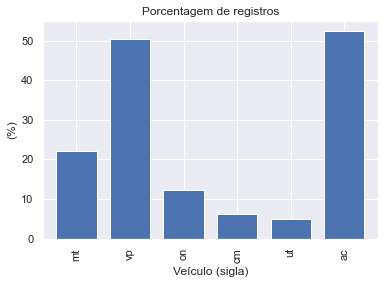

In [43]:
res_cnts = pd.DataFrame([resultado_busca[busca]['Contagem'] for busca in buscas], index=buscas, columns=['CONTAGEM'])

res_cnts['PORCENTAGEM'] = 100 * res_cnts['CONTAGEM'] / len(comando)
res_cnts.index.name = 'Veículo (sigla)'

ax = res_cnts['PORCENTAGEM'].plot.bar(width=0.75); 
ax.set(title='Porcentagem de registros', ylabel='(%)')
plt.show()

### Examinando Termos Encontrados

In [13]:
termos_encontrados = {}
for termo_busca in buscas:
    termos_encontrados[termo_busca] = list(np.unique(resultado_busca[termo_busca]['Palavras']))

### Selecionando termos para deconsiderar

In [14]:
sigla = input(f'Selecione uma sigla: {buscas}')
print(f'\nTermos encontrados para sigla ({sigla}):\n\n', termos_encontrados[sigla])

Selecione uma sigla: ['mt', 'vp', 'on', 'cm', 'ut', 'ac'] on



Termos encontrados para sigla (on):

 ['"conjunto', '"conscientização', '"encontro', '"mondial', '"monobloco"', '(abandonado)', '(concentração', '(conservação)', '(consorcio', '(construção', '(controlado)', '(ecoponte)', '(maratona', '(posicionamento', '(profissionais', '(seconserma', '(seconserma)', '(seconserva', '(seconserva)', '(sesconserma)', '(telefonia)', '(triathlon)', '-ayrton', '1on', '2ons', 'abandonado', 'abandonado.', 'abandono', 'acionadas', 'acionamento', 'aconteceu', 'aeronave', 'alunos/funcionarios', 'antonio', 'ayrton', 'barcelona', 'barcelona-sc"', 'betoneira', 'bolsonaro"', 'bonitos', 'bonsucesso', 'bonsucesso,', 'bonsucesso.', 'caminhoneiros', 'campeonato', 'catonho', 'cegonha', 'concentração', 'concessionaria', 'concreto', 'concreto)', 'concurso', 'cond', 'condicionado', 'condições', 'condominio', 'confraria', 'confronto', 'conjugado', 'conjunta', 'conjunto', 'conrado', 'conrado,', 'consciência', 'conservação', 'container', 'contenção', 'contra', 'controlado', 'c

#### Seleção manual:

In [32]:
try: out_siglas 
except: out_siglas = {}

try: outmask
except: out_mask = {}

if input('Freshstart?')!='s': ind = termos_encontrados[sigla].index(out_siglas[sigla][-1])
else: ind = 0
for word in termos_encontrados[sigla][ind:]:
    
    clear_output(wait=True);
    inp = input(f'Remover? ({word})');
        
    if inp=='exit': break;
    if inp=='s': out_mask[word]=True;

out_siglas[sigla] = [word for word in out_mask.keys() if out_mask[word]]

Remover? ("encontro) exit


In [31]:
out_mask

{}

In [137]:
out_ut = out; print(out_ut)

['(manutenção', '(manutenção)', '(outdoor)', 'adutora', 'aeronautas', 'auto', 'auto-estrada', 'autorizado', 'autorizado"', 'autorizado)', 'b19576xutxvp)', 'couto', 'dutra.', 'estrutura', 'estrutura.', 'frutas', 'luther', 'manut/limpeza', 'manutenção', 'mutera', 'nautico)', 'obra/outros', 'outdoor', 'outono"', 'outubro', 'souto', 'utilitario', 'viaduto', 'viaduto.']


---

# Extraindo Registros do Sistema Comando Contendo 'mt' (Moto)

In [44]:
comando['MOTO'] = comando.index.isin(resultado_busca['mt']['Index'])

In [45]:
com_mt = comando[comando['MOTO']]
#com_df.to_csv('Dados Limpos/Comando_Motos.csv')

In [46]:
print('Registros da tabela comando contendo "mt":', round(len(com_mt)/len(comando)*100, 2), '%')

Registros da tabela comando contendo "mt": 22.05 %


<empty space>

---

## Criando Série Temporal (Index do tipo 'datetime64[ns]')

In [59]:
cols = ['POP_TITULO', 'ORGAO_NOME', 'ACAO', 'MOTO']

time_ser = comando[cols].copy()
time_ser['EVENTO_INICIO'] = comando['EVENTO_INICIO'].astype('datetime64[s]')
time_ser = time_ser.set_index('EVENTO_INICIO')

In [107]:
series_range = (time_ser.index.max() - time_ser.index.min())
ser_m = time_ser.resample('M').sum()
monthly_accidents = time_ser['MOTO'].sum() / ser_m.shape[0]
daily_accidents = time_ser['MOTO'].sum() / series_range.days

print('Média Acidentes de Moto por Mês:', monthly_accidents)
print('Média Acidentes de Moto por Dia:', daily_accidents)

Média Acidentes de Moto por Mês: 508.08641975308643
Média Acidentes de Moto por Dia: 16.964138499587797


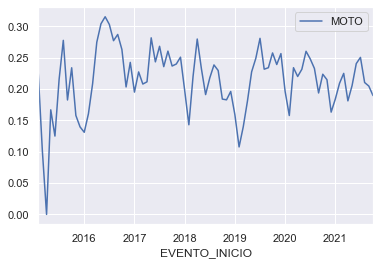

In [108]:
time_ser.resample('M').mean().plot()

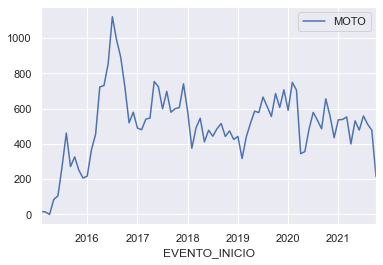

In [82]:
time_ser.resample('M').sum().plot()

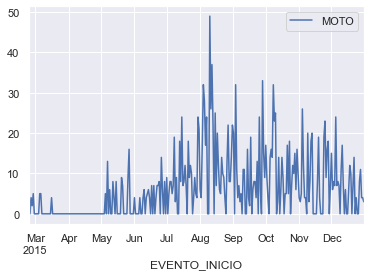

In [94]:
time_ser['2014':'2015'].resample('D').sum().plot()

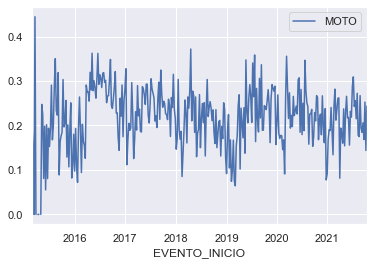

In [98]:
time_ser.resample('W').mean().plot()

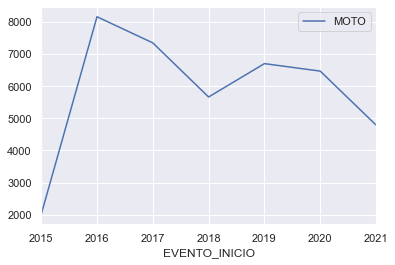

In [102]:
time_ser.resample('Y').sum().plot()